# Libraries and Directories

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from tqdm.auto import tqdm
import random
import seaborn as sns
from multiprocessing import Pool, cpu_count

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define root and stocks data directories
root_dir = '/content'
stocks_dir = '/content/drive/MyDrive/Past Stock Trading/Stocks'

# Data Preprocessing

## Loading and Saving Data

### Loading specified data files as a single dataframe

In [ ]:
def load_specified_data(data_dir, num_samples=10, random_sample=False, start_sample=None, end_sample=None, step_sample=None):
    """
    Load historical data for the specified stocks (CSV files) into a single pandas DataFrame.
    """

    try:
        csv_files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]
        if not csv_files:
          print("No csv files in the specified directory")
          return None

        if random_sample:
          selected_csv_files = random.sample(csv_files, num_samples)
        else:
          if start_sample == None and end_sample == None and step_sample == None:
            selected_csv_files = csv_files[0:num_samples:1]
          else:
            selected_csv_files = csv_files[start_sample:end_sample:step_sample]

        df_list = []
        for file in tqdm(selected_csv_files):
            file_path = os.path.join(data_dir, file)
            try:
                df = pd.read_csv(file_path)
                df['Stock'] = file.replace('.us.txt', '').upper()
                df.drop(columns=['OpenInt'], inplace=True)
                df_list.append(df)
            except pd.errors.EmptyDataError:
                print(f"Warning: Skipping empty file {file}")
            except pd.errors.ParserError:
                print(f"Warning: Skipping file with parsing error {file}")
            except Exception as e:
                print(f"Warning: Error reading file {file}: {e}")

        if not df_list:
            print("No valid CSV files to concatenate.")
            return None

        concatenated_df = pd.concat(df_list, ignore_index=True)
        return concatenated_df

    except FileNotFoundError:
        print(f"Directory not found: {root_dir}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [ ]:
# Display the concatenated DataFrame of the first 50 rows of the dataset
specified_data = load_specified_data(stocks_dir, num_samples=50)
print(specified_data)

### Test the system's RAM

Considering the total number of files (stocks) is ~7200, the previous load must be implemented 7200//50 = 144 times.

In [ ]:
rep_specified_data = pd.concat([specified_data]*144, ignore_index=True)
print(rep_specified_data)

                Date     Open     High      Low    Close  Volume  Stock
0         2016-04-14  25.7800  25.8000  24.7800  25.7900   75230  STT_G
1         2016-04-15  25.7956  25.8100  25.7500  25.7500  160744  STT_G
2         2016-04-18  25.8200  25.8400  25.7000  25.7600  192724  STT_G
3         2016-04-19  25.8400  25.9000  25.7900  25.8100  232248  STT_G
4         2016-04-20  25.8600  25.9400  25.8400  25.9100   58459  STT_G
...              ...      ...      ...      ...      ...     ...    ...
14872171  2017-11-06  29.5162  29.5162  29.5162  29.5162       0   TCTL
14872172  2017-11-07  29.5699  29.5700  29.5390  29.5390   10190   TCTL
14872173  2017-11-08  29.6090  29.6090  29.6090  29.6090     392   TCTL
14872174  2017-11-09  29.8400  29.8400  29.4920  29.4920    1479   TCTL
14872175  2017-11-10  29.4920  29.4920  29.4920  29.4920       0   TCTL

[14872176 rows x 7 columns]


### Loading (with batches) all data files as a single dataframe and saving it

In [ ]:
num_files = len(os.listdir(stocks_dir))
size_of_batch = 50
concat_df = pd.DataFrame()

for num_batch in tqdm(range(num_files//size_of_batch)):
  batch_df = load_specified_data(stocks_dir, start_sample=max(0, num_batch*size_of_batch),
                                 end_sample=min(num_files, (num_batch+1)*size_of_batch),
                                 step_sample=1)
  concat_df = pd.concat([concat_df, batch_df], ignore_index=True)
concat_df.to_csv(f"{stocks_dir.replace('Stocks','')}/complete_dataset.csv", index=False)

## Removing duplicate, missing, invalid or non-relative data

In [ ]:
# Import the complete dataframe
complete_df = pd.read_csv(f"{stocks_dir.replace('Stocks','')}/complete_dataset.csv")
print(complete_df)

                Date     Open   High    Low   Close  Volume  Stock
0         2016-04-14  25.7800  25.80  24.78  25.790   75230  STT_G
1         2016-04-15  25.7956  25.81  25.75  25.750  160744  STT_G
2         2016-04-18  25.8200  25.84  25.70  25.760  192724  STT_G
3         2016-04-19  25.8400  25.90  25.79  25.810  232248  STT_G
4         2016-04-20  25.8600  25.94  25.84  25.910   58459  STT_G
...              ...      ...    ...    ...     ...     ...    ...
14776627  2017-11-06  28.2000  28.48  28.20  28.480   17195    AGT
14776628  2017-11-07  28.5300  28.53  28.12  28.140    2468    AGT
14776629  2017-11-08  28.1000  28.16  28.04  28.049   20986    AGT
14776630  2017-11-09  27.9800  28.27  27.98  28.160    3601    AGT
14776631  2017-11-10  27.8000  27.80  27.78  27.790   11661    AGT

[14776632 rows x 7 columns]


In [ ]:
# General info
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14776632 entries, 0 to 14776631
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  int64  
 6   Stock   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 789.2+ MB


In [ ]:
# Check for duplicate rows
duplicate_rows = complete_df[complete_df.duplicated()]
print("Duplicate Rows:")
print(duplicate_rows)

# Remove duplicate rows
updated_1_df = complete_df.drop_duplicates()

# Check for missing values
missing_values = updated_1_df.isnull().sum()
print("\nMissing Values per column:")
print(missing_values)

# Remove rows with any missing values
updated_2_df = updated_1_df.dropna()

Duplicate Rows:
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Stock]
Index: []

Missing Values per column:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Stock     0
dtype: int64


In [ ]:
# Check for zero or negative values in specified columns
columns_to_check = ['Open', 'High', 'Low', 'Close']
invalid_rows = updated_2_df[
    (updated_2_df[columns_to_check] <= 0).any(axis=1)
]

# Create an updated DataFrame without the rows containing invalid values
updated_3_df = updated_2_df[
    (updated_2_df[columns_to_check] > 0).all(axis=1)
]

# Print some info
print("Number of invalid rows:", len(invalid_rows))
print("Number of rows in the updated_3 DataFrame:", len(updated_3_df))

Number of invalid rows: 28
Number of rows in the updated_3 DataFrame: 14776604


In [ ]:
print(invalid_rows)

                Date     Open      High  Low     Close   Volume Stock
136462    2005-12-09   0.1500    0.1500  0.0    0.1500      100   SYN
822086    2010-08-02   5.9553    7.4685  0.0    7.4106    65133   UMH
1567890   2010-08-05  97.0170   97.0170  0.0   95.9600    77168  WMLP
1767488   2006-02-22   6.9085    7.0559  0.0    7.0559  1078670   WPM
2262011   2010-08-13  35.1000   35.1000  0.0   34.2000     1145   PTX
2262015   2010-08-20  31.2000   31.2000  0.0   29.5000     5470   PTX
3643153   2007-05-23   0.0000   20.9900  0.0   20.9900        0  SPTL
3643154   2007-05-24   0.0000   20.9980  0.0   20.9980        0  SPTL
3643155   2007-05-25   0.0000   20.9900  0.0   20.9900        0  SPTL
3643156   2007-05-29   0.0000   21.0600  0.0   21.0600        0  SPTL
3645745   2007-05-23   0.0000   21.6040  0.0   21.6040        0  SPAB
3645746   2007-05-24   0.0000   21.6040  0.0   21.6040        0  SPAB
3645747   2007-05-25   0.0000   21.5970  0.0   21.5970        0  SPAB
3645748   2007-05-29

In [ ]:
# Calculate the daily percentage change for each column
updated_3_df = updated_3_df.copy()
for column in ['Open', 'High', 'Low', 'Close']:
  updated_3_df.loc[:, f'{column}_pct_change'] = updated_3_df.groupby('Stock')[column].pct_change()

# Define a threshold for sudden changes (e.g., 1000%)
threshold = 10

# Identify rows with sudden increases or decreases
sudden_changes = updated_3_df[
    (updated_3_df['Open_pct_change'].abs() > threshold) |
    (updated_3_df['High_pct_change'].abs() > threshold) |
    (updated_3_df['Low_pct_change'].abs() > threshold) |
    (updated_3_df['Close_pct_change'].abs() > threshold)
]

# Create an updated DataFrame without the rows with sudden changes
updated_4_df = updated_3_df[
    ~(
        (updated_3_df['Open_pct_change'].abs() > threshold) |
        (updated_3_df['High_pct_change'].abs() > threshold) |
        (updated_3_df['Low_pct_change'].abs() > threshold) |
        (updated_3_df['Close_pct_change'].abs() > threshold)
    )
]

updated_4_df = updated_4_df.drop(columns=['Open_pct_change', 'High_pct_change', 'Low_pct_change', 'Close_pct_change']).copy()

# Print some info
print("Number of rows with sudden changes:", len(sudden_changes))
print("Number of rows in the updated_4 DataFrame:", len(updated_4_df))

Number of rows with sudden changes: 87
Number of rows in the updated_4 DataFrame: 14776517


In [ ]:
# Group data by stock
grouped = updated_4_df.groupby('Stock')

# Filter out stocks with less than 100 rows
stocks_to_keep = grouped.size()[grouped.size() >= 100].index
updated_5_df = updated_4_df[updated_4_df['Stock'].isin(stocks_to_keep)]

# Filter out rows with volume less than 10
updated_6_df = updated_5_df[updated_5_df['Volume'] >= 10]

# Calculate all-time high for each stock
all_time_high = grouped['High'].max()

# Filter out stocks with all-time-high less than $10
stocks_to_keep = all_time_high[all_time_high >= 10].index
updated_7_df = updated_6_df[updated_6_df['Stock'].isin(stocks_to_keep)]

# Find the dates of all-time high and low for each stock
all_time_high_dates = grouped.apply(lambda x: x.loc[x['High'].idxmax(), 'Date'], include_groups=False)
all_time_low_dates = grouped.apply(lambda x: x.loc[x['Low'].idxmin(), 'Date'], include_groups=False)

# Convert date strings to datetime objects for comparison
all_time_high_dates = pd.to_datetime(all_time_high_dates)
all_time_low_dates = pd.to_datetime(all_time_low_dates)

# Filter out stocks where all-time-high happened before or at the same day as all-time-low
stocks_to_keep = all_time_high_dates[all_time_high_dates > all_time_low_dates].index
updated_8_df = updated_7_df[updated_7_df['Stock'].isin(stocks_to_keep)]

# The updated3_df now contains the updated DataFrame without the specified rows.
print("Number of rows in the updated_8 DataFrame:", len(updated_8_df))

Number of rows in the updated_8 DataFrame: 9796652


In [ ]:
updated_8_df.to_csv(f"{stocks_dir.replace('Stocks','')}updated_8_dataset.csv", index=False)

In [ ]:
# Count the number of unique stocks
num_stocks = updated_8_df['Stock'].nunique()
print(f"Number of different stocks in updated_8_df: {num_stocks}")

Number of different stocks in updated_8_df: 4099


# Exploratory Data Analysis (EDA)

In [ ]:
# Import the final dataframe
updated_8_df = pd.read_csv(f"{stocks_dir.replace('Stocks','')}updated_8_dataset.csv")
print(updated_8_df)

               Date     Open   High    Low   Close  Volume  Stock
0        2016-04-14  25.7800  25.80  24.78  25.790   75230  STT_G
1        2016-04-15  25.7956  25.81  25.75  25.750  160744  STT_G
2        2016-04-18  25.8200  25.84  25.70  25.760  192724  STT_G
3        2016-04-19  25.8400  25.90  25.79  25.810  232248  STT_G
4        2016-04-20  25.8600  25.94  25.84  25.910   58459  STT_G
...             ...      ...    ...    ...     ...     ...    ...
9796647  2017-11-06  28.2000  28.48  28.20  28.480   17195    AGT
9796648  2017-11-07  28.5300  28.53  28.12  28.140    2468    AGT
9796649  2017-11-08  28.1000  28.16  28.04  28.049   20986    AGT
9796650  2017-11-09  27.9800  28.27  27.98  28.160    3601    AGT
9796651  2017-11-10  27.8000  27.80  27.78  27.790   11661    AGT

[9796652 rows x 7 columns]


In [ ]:
# General info
updated_8_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9796652 entries, 0 to 9796651
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  int64  
 6   Stock   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 523.2+ MB


In [ ]:
# Calculate number and frequency of unique values per variable
for attribute in updated_8_df.columns:
    num_unique_values = updated_8_df[attribute].nunique()
    print(f"Number of unique values of the attribute '{attribute}': {num_unique_values}")
    frequency_unique_values = updated_8_df[attribute].value_counts()
    print(f"Frequency of each value of {frequency_unique_values}\n")

Number of unique values of the attribute 'Date': 14084
Frequency of each value of Date
2017-09-05    3958
2017-09-11    3951
2017-10-18    3950
2017-10-03    3950
2017-08-31    3950
              ... 
1962-11-09       1
2016-03-05       1
2016-02-27       1
1978-03-24       1
2016-06-25       1
Name: count, Length: 14084, dtype: int64

Number of unique values of the attribute 'Open': 254778
Frequency of each value of Open
25.0000    2862
10.0000    2633
26.0000    2380
25.5000    2269
4.0000     1995
           ... 
26.0465       1
25.6284       1
25.3819       1
26.2365       1
27.8316       1
Name: count, Length: 254778, dtype: int64

Number of unique values of the attribute 'High': 274885
Frequency of each value of High
25.0000     2565
10.0000     2556
26.0000     2270
25.5000     2240
11.0000     2070
            ... 
468.6900       1
466.7600       1
464.3500       1
466.5300       1
27.5033        1
Name: count, Length: 274885, dtype: int64

Number of unique values of the attrib

In [ ]:
# Basic statistic properties for each variable
updated_8_df.describe()

,Open,High,Low,Close,Volume
count,9.796652e+06,9.796652e+06,9.796652e+06,9.796652e+06,9.796652e+06
mean,9.519338e+01,9.595113e+01,9.438802e+01,9.520610e+01,1.948233e+06
std,3.008267e+03,3.025308e+03,2.988760e+03,3.008108e+03,8.993045e+06
min,7.910000e-03,7.910000e-03,6.670000e-03,7.910000e-03,1.000000e+01
25%,1.013900e+01,1.025900e+01,1.001300e+01,1.014000e+01,4.678000e+04
50%,1.900200e+01,1.925000e+01,1.875000e+01,1.900800e+01,2.595130e+05
75%,3.240800e+01,3.282000e+01,3.199400e+01,3.241700e+01,1.164548e+06
max,2.853500e+05,2.859500e+05,2.843350e+05,2.845700e+05,2.423735e+09


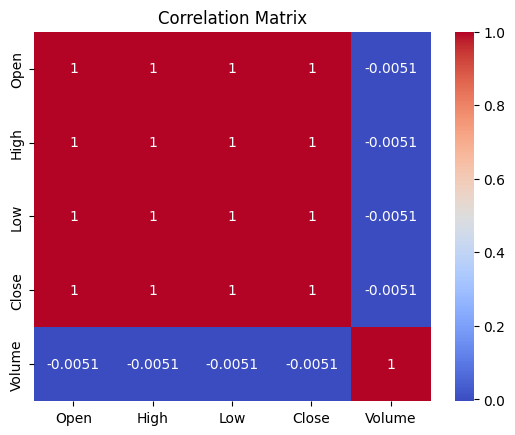

In [ ]:
# Correlation between numeric variables
numeric_columns = updated_8_df.select_dtypes(include=[np.number]).columns
correlation_matrix = updated_8_df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
sns.set(rc={'figure.figsize': (6, 4)})

<ipython-input-18-5b5a783dd08b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks_df['Date'] = pd.to_datetime(top_stocks_df['Date'])
<ipython-input-18-5b5a783dd08b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks_df['Year'] = top_stocks_df['Date'].dt.year


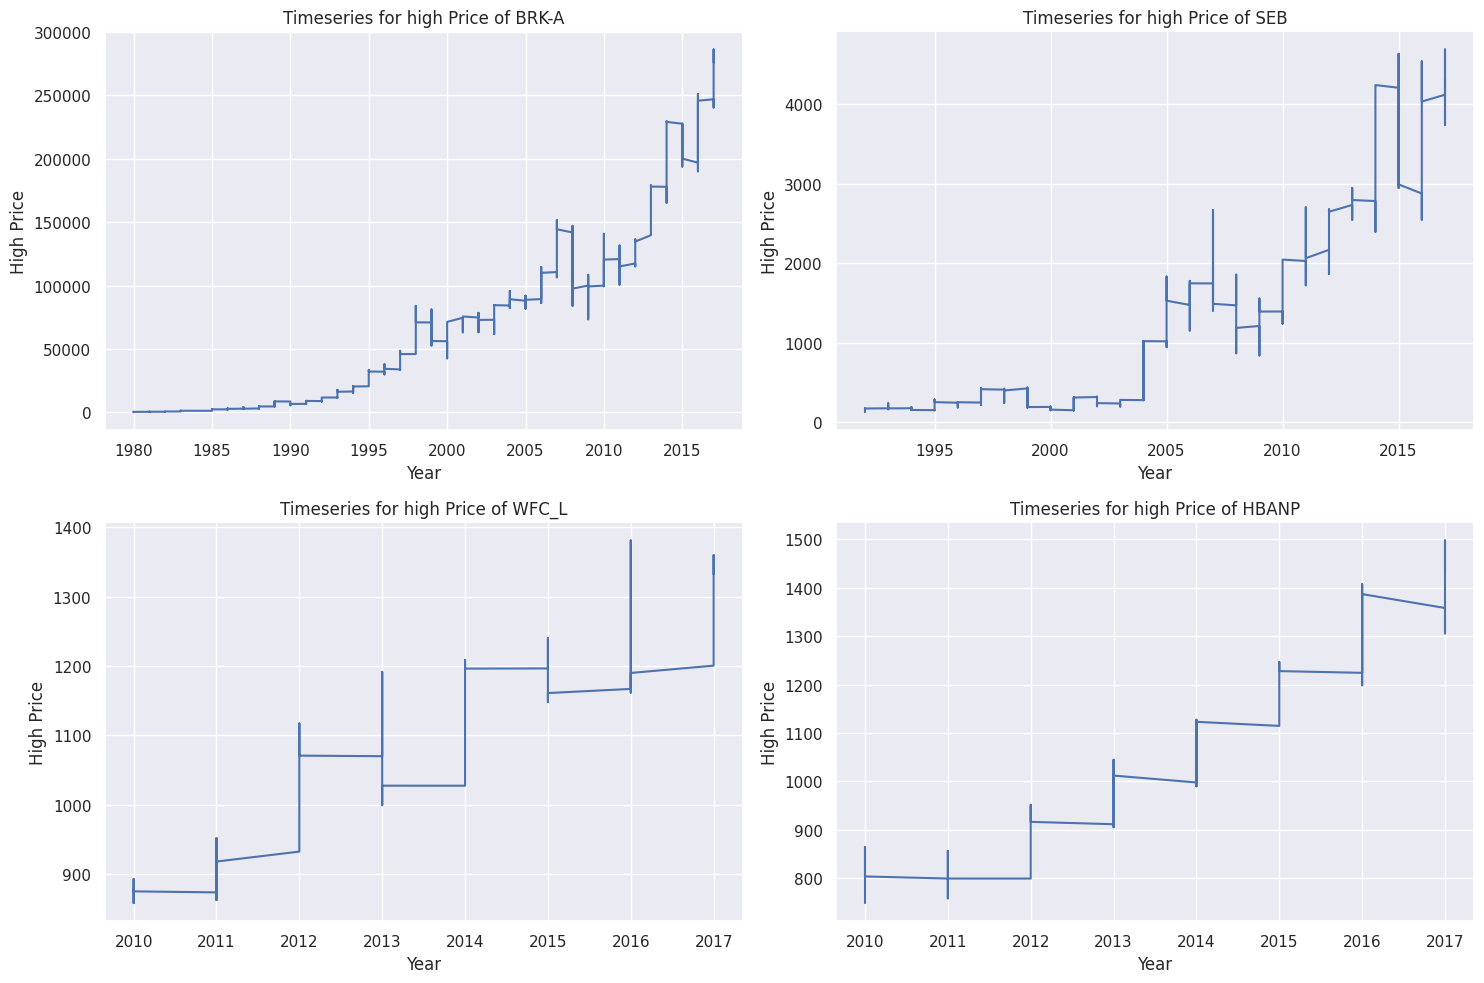

In [ ]:
def plot_top_stocks_high_prices(dataframe):
    """
    Plots the time series of the 'High' price for the 4 stocks with the highest average 'High' price.

    Args:
        dataframe: A pandas DataFrame with 'Stock', 'Date', and 'High' columns.
    """

    # Calculate the average high price for each stock
    avg_high_prices = dataframe.groupby('Stock')['High'].mean()

    # Get the top 4 stocks
    top_4_stocks = avg_high_prices.nlargest(4).index

    # Filter the DataFrame to include only the top 4 stocks
    top_stocks_df = dataframe[dataframe['Stock'].isin(top_4_stocks)]

    # Convert 'Date' to datetime objects and extract years
    top_stocks_df['Date'] = pd.to_datetime(top_stocks_df['Date'])
    top_stocks_df['Year'] = top_stocks_df['Date'].dt.year

    # Create subplots for each stock
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()  # Flatten the axes array for easier iteration

    for i, stock in enumerate(top_4_stocks):
        stock_df = top_stocks_df[top_stocks_df['Stock'] == stock]
        axes[i].plot(stock_df['Year'], stock_df['High'])
        axes[i].set_title(f'Timeseries for high Price of {stock}')
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel('High Price')

    plt.tight_layout()
    plt.show()

plot_top_stocks_high_prices(updated_8_df)

# Time-Travel Stock Trading Algorithm v1

In [30]:
updated_8_df = pd.read_csv(f"{stocks_dir.replace('Stocks','')}updated_8_dataset.csv")
print(updated_8_df)

               Date     Open   High    Low   Close  Volume  Stock
0        2016-04-14  25.7800  25.80  24.78  25.790   75230  STT_G
1        2016-04-15  25.7956  25.81  25.75  25.750  160744  STT_G
2        2016-04-18  25.8200  25.84  25.70  25.760  192724  STT_G
3        2016-04-19  25.8400  25.90  25.79  25.810  232248  STT_G
4        2016-04-20  25.8600  25.94  25.84  25.910   58459  STT_G
...             ...      ...    ...    ...     ...     ...    ...
9796647  2017-11-06  28.2000  28.48  28.20  28.480   17195    AGT
9796648  2017-11-07  28.5300  28.53  28.12  28.140    2468    AGT
9796649  2017-11-08  28.1000  28.16  28.04  28.049   20986    AGT
9796650  2017-11-09  27.9800  28.27  27.98  28.160    3601    AGT
9796651  2017-11-10  27.8000  27.80  27.78  27.790   11661    AGT

[9796652 rows x 7 columns]


In [32]:
def stock_trading_algorithm_v1(dataframe, initial_balance=1, small_limit_num_trades=1000, large_limit_num_trades=1000000):

    trades_fee = {'buy': 1.01, 'sell': 0.99}  # 1% commission per trade
    trades_limit = 0.1  # 10% of the stock volume per trade
    balance = initial_balance
    trades_log = []
    valuations_log = []

    # Calculate price swings
    dataframe = dataframe.sort_values(by='Date')
    dataframe['PriceSwing_1'] = (trades_fee['sell'] * dataframe['High']
                                -trades_fee['buy'] * dataframe['Open']) * dataframe['Volume']
    dataframe['PriceSwing_2'] = (trades_fee['sell'] * dataframe['Close']
                                -trades_fee['buy'] * dataframe['Low']) * dataframe['Volume']

    # Drop 0 or negative price swings
    dataframe = dataframe[(dataframe['PriceSwing_1'] > 0) | (dataframe['PriceSwing_2'] > 0)]

    # Rank stocks based on price swings
    dataframe['SwingRank_1'] = dataframe.groupby('Date')['PriceSwing_1'].rank(ascending=False)
    dataframe['SwingRank_2'] = dataframe.groupby('Date')['PriceSwing_2'].rank(ascending=False)
    dataframe['StockScore'] = dataframe['SwingRank_1'] + dataframe['SwingRank_2']

    # Rank stocks based on stock score and remove unecessary columns
    ranked_df = dataframe.sort_values(['Date', 'StockScore'], ascending=[True, False])
    ranked_df = ranked_df.copy()
    ranked_df.drop(columns=['SwingRank_1', 'SwingRank_2'], inplace=True)

    for date in tqdm(ranked_df['Date'].unique()):
        date_df = ranked_df[ranked_df['Date'] == date].copy()

        # Find affordable stock with maximum priceswing for each date
        date_df = date_df[(date_df['Open'] < balance) | (date_df['Low'] < balance)]

        if date_df.empty:
            continue

        date_df['MaxPriceSwing'] = date_df[['PriceSwing_1', 'PriceSwing_2']].max(axis=1)

        max_swing_row = date_df.loc[date_df['MaxPriceSwing'].idxmax()]
        stock = max_swing_row['Stock']
        open_price = max_swing_row['Open']
        low_price = max_swing_row['Low']
        high_price = max_swing_row['High']
        close_price = max_swing_row['Close']
        volume = max_swing_row['Volume']
        max_shares = int(volume * trades_limit)

        if max_swing_row['PriceSwing_1'] > max_swing_row['PriceSwing_2']:
            # Buy-Open -> Sell-High Rule
            if (len(trades_log) < large_limit_num_trades and balance >= open_price * trades_fee['buy']):

                # Buy-Open
                buy_open_quantity = min(max_shares//2, int(balance // (open_price * trades_fee['buy'])))
                cost = open_price * buy_open_quantity * trades_fee['buy']
                balance -= cost
                trades_log.append((date, 'buy-open', stock, buy_open_quantity, open_price))

                # Sell-High
                revenue = high_price * buy_open_quantity * trades_fee['sell']
                balance += revenue
                trades_log.append((date, 'sell-high', stock, buy_open_quantity, high_price))

        else:
            # Buy-Low -> Sell-Close Rule
            if (len(trades_log) < large_limit_num_trades and balance >= low_price * trades_fee['buy']):
                # Buy-Low
                buy_low_quantity = min(max_shares//2, int(balance // (low_price * trades_fee['buy'])))
                cost = low_price * buy_low_quantity * trades_fee['buy']
                balance -= cost
                trades_log.append((date, 'buy-low', stock, buy_low_quantity, low_price))

                # Sell-Close
                revenue = close_price * buy_low_quantity * trades_fee['sell']
                balance += revenue
                trades_log.append((date, 'sell-close', stock, buy_low_quantity, close_price))

        # Valuation at the end of the day
        valuations_log.append((date, balance))

        # Print progress
        index = np.where(ranked_df['Date'].unique() == date)[0][0]
        if index % 200 == 0 or len(trades_log) % 200 == 0:
            print(f'Date: {date}. Balance: {balance}. Total trades: {len(trades_log)}')

        # Break if large_limit_num_trades reached
        if len(trades_log) >= large_limit_num_trades:
            print(f'Date: {date}. Balance: {balance}. Total trades: {len(trades_log)}')
            break

    # Save small and large solutions
    with open(f'small_v1_limit_{small_limit_num_trades}.txt', 'w') as f:
        limit = min(small_limit_num_trades, len(trades_log))
        f.write(f"{limit}\n")
        for trade in trades_log[:limit]:
            f.write(f"{trade[0]} {trade[1]} {trade[2]} {trade[3]}\n")
    if len(trades_log) > small_limit_num_trades:
        with open(f'large_v1_limit_{large_limit_num_trades}.txt', 'w') as f:
            f.write(f"{len(trades_log)}\n")
            for trade in trades_log:
                f.write(f"{trade[0]} {trade[1]} {trade[2]} {trade[3]}\n")

    return trades_log, valuations_log

In [ ]:
trades_log, valuations_log = stock_trading_algorithm_v1(updated_8_df)

In [34]:
print(f"Total trades: {len(trades_log)}")
trades = [trades[:4] for trades in trades_log]
for trade in trades_log:
    print(trade)

Streaming output truncated to the last 5000 lines.
('2007-12-10', 'buy-low', 'CELG', 4345299, 23.605)
('2007-12-10', 'sell-close', 'CELG', 4345299, 24.59)
('2007-12-11', 'buy-open', 'CSCO', 5453797, 22.999)
('2007-12-11', 'sell-high', 'CSCO', 5453797, 23.95)
('2007-12-12', 'buy-low', 'BRK-B', 4187500, 93.4)
('2007-12-12', 'sell-close', 'BRK-B', 4187500, 96.18)
('2007-12-13', 'buy-low', 'BIIB', 1685552, 49.418)
('2007-12-13', 'sell-close', 'BIIB', 1685552, 53.342)
('2007-12-14', 'buy-low', 'BRK-B', 3787500, 90.9)
('2007-12-14', 'sell-close', 'BRK-B', 3787500, 95.08)
('2007-12-17', 'buy-open', 'C', 439181, 292.8)
('2007-12-17', 'sell-high', 'C', 439181, 303.84)
('2007-12-18', 'buy-low', 'BIDU', 4509488, 35.01)
('2007-12-18', 'sell-close', 'BIDU', 4509488, 37.3)
('2007-12-19', 'buy-low', 'MA', 2317247, 19.05)
('2007-12-19', 'sell-close', 'MA', 2317247, 20.484)
('2007-12-20', 'buy-low', 'CELG', 2991481, 20.63)
('2007-12-20', 'sell-close', 'CELG', 2991481, 24.745)
('2007-12-21', 'buy-low', 

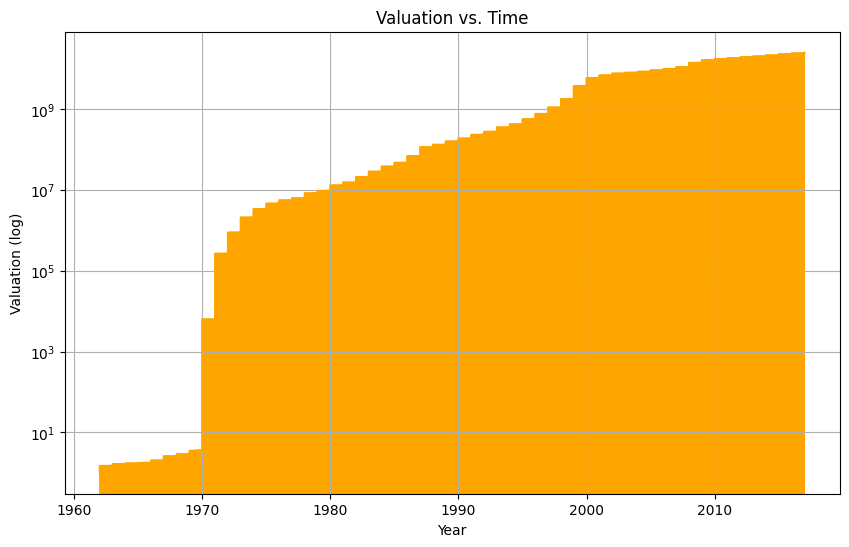

In [44]:
# Create a DataFrame from valuations_log
valuations_df = pd.DataFrame(valuations_log, columns=['Date', 'Valuation'])

# Convert 'Date' column to datetime objects
valuations_df['Date'] = pd.to_datetime(valuations_df['Date'])

# Extract year and round it to the nearest integer
valuations_df['Year'] = valuations_df['Date'].dt.year

# Plot Valuation vs. Time
plt.figure(figsize=(10, 6))
plt.plot(valuations_df['Year'], valuations_df['Valuation'], color='orange')
plt.fill_between(valuations_df['Year'], valuations_df['Valuation'], color='orange')

# Set logarithmic scale for y-axis
plt.yscale('log')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Valuation (log)')
plt.title('Valuation vs. Time')

# Set grid and show the plot
plt.grid(True)
plt.show()

# Time-Travel Stock Trading Algorithm v2

In [4]:
updated_8_df = pd.read_csv(f"{stocks_dir.replace('Stocks','')}updated_8_dataset.csv")
print(updated_8_df)

               Date     Open   High    Low   Close  Volume  Stock
0        2016-04-14  25.7800  25.80  24.78  25.790   75230  STT_G
1        2016-04-15  25.7956  25.81  25.75  25.750  160744  STT_G
2        2016-04-18  25.8200  25.84  25.70  25.760  192724  STT_G
3        2016-04-19  25.8400  25.90  25.79  25.810  232248  STT_G
4        2016-04-20  25.8600  25.94  25.84  25.910   58459  STT_G
...             ...      ...    ...    ...     ...     ...    ...
9796647  2017-11-06  28.2000  28.48  28.20  28.480   17195    AGT
9796648  2017-11-07  28.5300  28.53  28.12  28.140    2468    AGT
9796649  2017-11-08  28.1000  28.16  28.04  28.049   20986    AGT
9796650  2017-11-09  27.9800  28.27  27.98  28.160    3601    AGT
9796651  2017-11-10  27.8000  27.80  27.78  27.790   11661    AGT

[9796652 rows x 7 columns]


In [6]:
def stock_trading_algorithm_v2(dataframe, initial_balance=1, max_limit_num_trades=1000, text_filename='small_v2'):

  trades_fee = {'buy': 1.01, 'sell': 0.99}  # 1% commission per trade
  trades_limit = 0.1  # 10% of the stock volume per trade
  balance = initial_balance
  balances_log = {}
  portfolio_log = {}
  trades_log = {}
  valuations_log = {}
  best_trades_log = []

  # Experiment with limit_num_trades
  for limit_num_trades in tqdm(range(0, max_limit_num_trades + 1, (max_limit_num_trades)//2)):

    if limit_num_trades == 0:
      limit_num_trades = 2
    print(f'Limit of number of trades: {limit_num_trades}')
    temp_balance = initial_balance
    balances_log[limit_num_trades] = []
    portfolio_log[limit_num_trades] = []
    trades_log[limit_num_trades] = []
    valuations_log[limit_num_trades] = []

    # Calculate time periods of 1 trade each (buy-low,sell-high pair)
    time_periods = pd.date_range(start=dataframe['Date'].min(), end=dataframe['Date'].max(), periods=limit_num_trades//2+1)

    # Iterate through time periods
    for i in tqdm(range(len(time_periods)-1)):

      start_date = time_periods[i]
      end_date = time_periods[i + 1]

      # Filter data for the current time period
      period_data = dataframe[(dataframe['Date'] >= start_date.strftime('%Y-%m-%d')) & (dataframe['Date'] < end_date.strftime('%Y-%m-%d'))]

      # Find stocks with Low prices less than temp_balance
      eligible_stocks = period_data[(period_data['Low'] * trades_fee['buy']) <= temp_balance]['Stock'].unique()

      max_profit = 0
      best_trade_per_period = None
      b_log = []
      v_log = []
      p_log = []

      # Find the stock with the maximum price difference
      for stock in eligible_stocks:
        stock_data = period_data[period_data['Stock'] == stock]

        date_low = stock_data.loc[stock_data['Low'].idxmin(), 'Date']
        date_high = stock_data.loc[stock_data['High'].idxmax(), 'Date']
        if date_low >= date_high:
          continue

        min_low = stock_data['Low'].min()
        max_high = stock_data['High'].max()
        volume_low = stock_data.loc[stock_data['Low'].idxmin(), 'Volume']
        volume_high = stock_data.loc[stock_data['High'].idxmax(), 'Volume']
        close_low = stock_data.loc[stock_data['Low'].idxmin(), 'Close']

        buy_low_quantity = min((volume_low * trades_limit)//2, int(temp_balance // (min_low * trades_fee['buy'])))
        sell_high_quantity = min((volume_high * trades_limit)//2, buy_low_quantity)

        profit = (max_high * sell_high_quantity * trades_fee['sell']
                  -min_low * buy_low_quantity * trades_fee['buy'])

        if profit > max_profit:
          max_profit = profit
          b_log = ((date_low, temp_balance-(min_low * buy_low_quantity * trades_fee['buy'])),
                   (date_high, temp_balance+(max_high * sell_high_quantity * trades_fee['sell'])))

          p_log = ((date_low, stock, buy_low_quantity),
                   (date_high, stock, max(buy_low_quantity - volume_high * trades_limit, 0)))

          v_log = ((date_low, temp_balance+(close_low* buy_low_quantity * trades_fee['sell'])),
                   (date_high, temp_balance+(max_high * sell_high_quantity * trades_fee['sell'])))

          best_trade_per_period = ((date_low, 'buy-low', stock, buy_low_quantity, min_low),
                                   (date_high, 'sell-high', stock, sell_high_quantity, max_high))


      # Store the best trade for the current period
      if best_trade_per_period is not None:
        temp_balance += max_profit
        balances_log[limit_num_trades].extend([b_log[0], b_log[1]])
        portfolio_log[limit_num_trades].extend([p_log[0], p_log[1]])
        valuations_log[limit_num_trades].extend([v_log[0], v_log[1]])
        trades_log[limit_num_trades].extend([best_trade_per_period[0], best_trade_per_period[1]])

      if len(trades_log[limit_num_trades]) >= limit_num_trades:
        break

    print(f'Final balance: {temp_balance}. Total trades: {len(trades_log[limit_num_trades])}.\n{"-"*100}')
    # Save solution
    with open(f'{text_filename}_limit_{limit_num_trades}.txt', 'w') as f:
      f.write(f"{len(trades_log[limit_num_trades])}\n")
      for trade in trades_log[limit_num_trades]:
        f.write(f"{trade[0]} {trade[1]} {trade[2]} {trade[3]}\n")

    if temp_balance > balance:
      balance = temp_balance
      best_trades_log = trades_log[limit_num_trades]

  print(f'Best final balance: {balance}. Total trades: {len(best_trades_log)}')
  # Save solution
  with open(f'{text_filename}.txt', 'w') as f:
    f.write(f"{len(best_trades_log)}\n")
    for trade in best_trades_log:
      f.write(f"{trade[0]} {trade[1]} {trade[2]} {trade[3]}\n")

  return balances_log, portfolio_log, valuations_log, trades_log

In [ ]:
balances_log, portfolio_log, valuations_log, trades_log = stock_trading_algorithm_v2(updated_8_df)

In [ ]:
balances_log, portfolio_log, valuations_log, trades_log = stock_trading_algorithm_v2(updated_8_df)

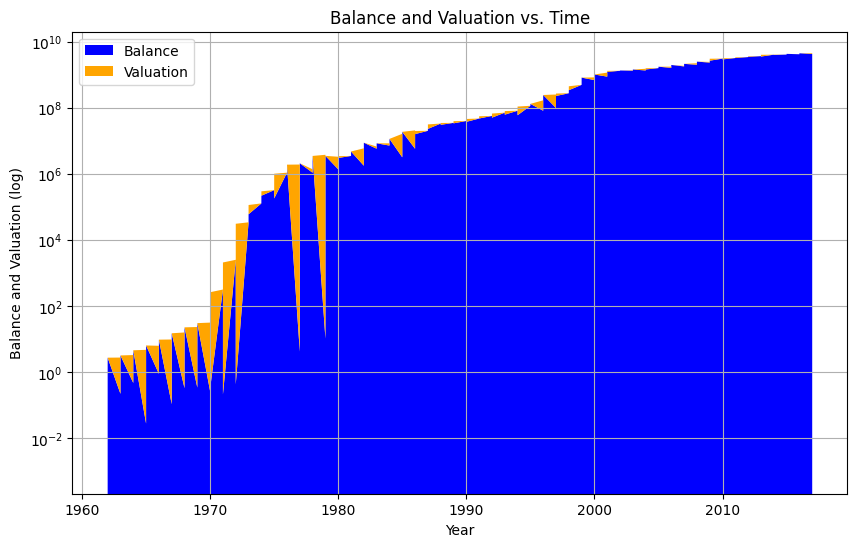

In [23]:
# Create a DataFrame from balances_log and valuations_log
valuations_df = pd.DataFrame([(k, *v) for k, values in valuations_log.items() for v in values], columns=['Limit', 'Date', 'Valuation'])
balances_df = pd.DataFrame([(k, *v) for k, values in balances_log.items() for v in values], columns=['Limit', 'Date', 'Balance'])

# Convert 'Date' column to datetime objects
valuations_df['Date'] = pd.to_datetime(valuations_df['Date'])
balances_df['Date'] = pd.to_datetime(balances_df['Date'])

# Extract year and round it to the nearest integer
valuations_df['Year'] = valuations_df['Date'].dt.year
balances_df['Year'] = balances_df['Date'].dt.year

# Filter the DataFrames based on a specific limit
limit_num_trades = 1000  # Example limit
valuations_df_filtered = valuations_df[valuations_df['Limit'] == limit_num_trades]
balances_df_filtered = balances_df[balances_df['Limit'] == limit_num_trades]

# Plot Balance vs Time and Valuation vs. Time
plt.figure(figsize=(10, 6))
plt.stackplot(balances_df_filtered['Year'], balances_df_filtered['Balance'],
              valuations_df_filtered['Valuation']-balances_df_filtered['Balance'],
              labels=['Balance', 'Valuation'], colors=['blue','orange'])

# Set logarithmic scale for y-axis
plt.yscale('log')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Balance and Valuation (log)')
plt.legend()
plt.title('Balance and Valuation vs. Time')

# Set grid and show the plot
plt.grid(True)
plt.show()

In [24]:
def stock_trading_algorithm_v2(dataframe, initial_balance=1, max_limit_num_trades=10000, text_filename='large_v2'):

  trades_fee = {'buy': 1.01, 'sell': 0.99}  # 1% commission per trade
  trades_limit = 0.1  # 10% of the stock volume per trade
  balance = initial_balance
  balances_log = {}
  portfolio_log = {}
  trades_log = {}
  valuations_log = {}
  best_trades_log = []

  # Experiment with limit_num_trades
  for limit_num_trades in tqdm(range(0, max_limit_num_trades + 1, (max_limit_num_trades))):

    if limit_num_trades == 0:
      limit_num_trades = 2
    print(f'Limit of number of trades: {limit_num_trades}')
    temp_balance = initial_balance
    balances_log[limit_num_trades] = []
    portfolio_log[limit_num_trades] = []
    trades_log[limit_num_trades] = []
    valuations_log[limit_num_trades] = []

    # Calculate time periods of 1 trade each (buy-low,sell-high pair)
    time_periods = pd.date_range(start=dataframe['Date'].min(), end=dataframe['Date'].max(), periods=limit_num_trades//2+1)

    # Iterate through time periods
    for i in tqdm(range(len(time_periods)-1)):

      start_date = time_periods[i]
      end_date = time_periods[i + 1]

      # Filter data for the current time period
      period_data = dataframe[(dataframe['Date'] >= start_date.strftime('%Y-%m-%d')) & (dataframe['Date'] < end_date.strftime('%Y-%m-%d'))]

      # Find stocks with Low prices less than temp_balance
      eligible_stocks = period_data[(period_data['Low'] * trades_fee['buy']) <= temp_balance]['Stock'].unique()

      max_profit = 0
      best_trade_per_period = None
      b_log = []
      v_log = []
      p_log = []

      # Find the stock with the maximum price difference
      for stock in eligible_stocks:
        stock_data = period_data[period_data['Stock'] == stock]

        date_low = stock_data.loc[stock_data['Low'].idxmin(), 'Date']
        date_high = stock_data.loc[stock_data['High'].idxmax(), 'Date']
        if date_low >= date_high:
          continue

        min_low = stock_data['Low'].min()
        max_high = stock_data['High'].max()
        volume_low = stock_data.loc[stock_data['Low'].idxmin(), 'Volume']
        volume_high = stock_data.loc[stock_data['High'].idxmax(), 'Volume']
        close_low = stock_data.loc[stock_data['Low'].idxmin(), 'Close']

        buy_low_quantity = min((volume_low * trades_limit)//2, int(temp_balance // (min_low * trades_fee['buy'])))
        sell_high_quantity = min((volume_high * trades_limit)//2, buy_low_quantity)

        profit = (max_high * sell_high_quantity * trades_fee['sell']
                  -min_low * buy_low_quantity * trades_fee['buy'])

        if profit > max_profit:
          max_profit = profit
          b_log = ((date_low, temp_balance-(min_low * buy_low_quantity * trades_fee['buy'])),
                   (date_high, temp_balance+(max_high * sell_high_quantity * trades_fee['sell'])))

          p_log = ((date_low, stock, buy_low_quantity),
                   (date_high, stock, max(buy_low_quantity - volume_high * trades_limit, 0)))

          v_log = ((date_low, temp_balance+(close_low* buy_low_quantity * trades_fee['sell'])),
                   (date_high, temp_balance+(max_high * sell_high_quantity * trades_fee['sell'])))

          best_trade_per_period = ((date_low, 'buy-low', stock, buy_low_quantity, min_low),
                                   (date_high, 'sell-high', stock, sell_high_quantity, max_high))


      # Store the best trade for the current period
      if best_trade_per_period is not None:
        temp_balance += max_profit
        balances_log[limit_num_trades].extend([b_log[0], b_log[1]])
        portfolio_log[limit_num_trades].extend([p_log[0], p_log[1]])
        valuations_log[limit_num_trades].extend([v_log[0], v_log[1]])
        trades_log[limit_num_trades].extend([best_trade_per_period[0], best_trade_per_period[1]])

      if len(trades_log[limit_num_trades]) >= limit_num_trades:
        break

    print(f'Final balance: {temp_balance}. Total trades: {len(trades_log[limit_num_trades])}.\n{"-"*100}')
    # Save solution
    with open(f'{text_filename}_limit_{limit_num_trades}.txt', 'w') as f:
      f.write(f"{len(trades_log[limit_num_trades])}\n")
      for trade in trades_log[limit_num_trades]:
        f.write(f"{trade[0]} {trade[1]} {trade[2]} {trade[3]}\n")

    if temp_balance > balance:
      balance = temp_balance
      best_trades_log = trades_log[limit_num_trades]

  print(f'Best final balance: {balance}. Total trades: {len(best_trades_log)}')
  # Save solution
  with open(f'{text_filename}.txt', 'w') as f:
    f.write(f"{len(best_trades_log)}\n")
    for trade in best_trades_log:
      f.write(f"{trade[0]} {trade[1]} {trade[2]} {trade[3]}\n")

  return balances_log, portfolio_log, valuations_log, trades_log

In [ ]:
balances_log, portfolio_log, valuations_log, trades_log = stock_trading_algorithm_v2(updated_8_df)

In [30]:
# Create a DataFrame from balances_log and valuations_log
valuations_df = pd.DataFrame([(k, *v) for k, values in valuations_log.items() for v in values], columns=['Limit', 'Date', 'Valuation'])
balances_df = pd.DataFrame([(k, *v) for k, values in balances_log.items() for v in values], columns=['Limit', 'Date', 'Balance'])

# Convert 'Date' column to datetime objects
valuations_df['Date'] = pd.to_datetime(valuations_df['Date'])
balances_df['Date'] = pd.to_datetime(balances_df['Date'])

# Extract year and round it to the nearest integer
valuations_df['Year'] = valuations_df['Date'].dt.year
balances_df['Year'] = balances_df['Date'].dt.year

# Filter the DataFrames based on a specific limit
limit_num_trades = 1000000  # Example limit
valuations_df_filtered = valuations_df[valuations_df['Limit'] == limit_num_trades]
balances_df_filtered = balances_df[balances_df['Limit'] == limit_num_trades]

# Calculate the difference between Valuation and Balance, ensuring it's positive
diff = valuations_df_filtered['Valuation'] - balances_df_filtered['Balance']
diff[diff <= 0] = 1e-10  # Replace non-positive values with a small positive value

# Plot Balance vs Time and Valuation vs. Time
plt.figure(figsize=(10, 6))
plt.stackplot(balances_df_filtered['Year'], balances_df_filtered['Balance'],
              diff, # Use the modified difference here
              labels=['Balance', 'Valuation'], colors=['blue','orange'])

# Set logarithmic scale for y-axis
plt.yscale('log')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Balance and Valuation (log)')
plt.legend()
plt.title('Balance and Valuation vs. Time')

# Set grid and show the plot
plt.grid(True)
plt.show()

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1000x600 with 1 Axes>